#  CottonNet: Cotton Disease Prediction using ResNet152V2
### Using Advanced techniques like :
* Transfer Learning
* Data Augmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

## Fetch / Load the data

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d janmejaybhoi/cotton-disease-dataset

 99% 147M/148M [00:07<00:00, 25.6MB/s]
100% 148M/148M [00:07<00:00, 20.7MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cotton-disease-dataset.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

## Data Augmentation

In [9]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [10]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    '/content/Cotton Disease/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Cotton Disease/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1951 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


## Build the CNN model

### Load the Resnet152V2 model and freeze its conv_base

In [12]:
model = ResNet152V2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

234545216/234545216 [==============================] - 11s 0us/step


In [13]:
for layer in model.layers:
  layer.trainable = False

In [14]:
flatten = Flatten()(model.output)
dense1 = Dense(64, activation='relu')(flatten)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(4, activation='softmax')(dense2)

resnet_v2 = Model(inputs=model.input, outputs=output)

In [15]:
resnet_v2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
resnet_v2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [17]:
history = resnet_v2.fit_generator(train_generator, epochs=20, validation_data=test_generator)

<ipython-input-17-a4236179cc7d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet_v2.fit_generator(train_generator, epochs=20, validation_data=test_generator)


Epoch 1/20
61/61 [==============================] - 67s 776ms/step - loss: 1.2988 - accuracy: 0.7560 - val_loss: 0.7369 - val_accuracy: 0.8679
Epoch 2/20
61/61 [==============================] - 42s 685ms/step - loss: 0.5434 - accuracy: 0.8754 - val_loss: 0.5525 - val_accuracy: 0.8962
Epoch 3/20
61/61 [==============================] - 42s 681ms/step - loss: 0.5362 - accuracy: 0.8672 - val_loss: 0.6078 - val_accuracy: 0.8585
Epoch 4/20
61/61 [==============================] - 41s 674ms/step - loss: 0.4892 - accuracy: 0.8857 - val_loss: 0.3308 - val_accuracy: 0.9245
Epoch 5/20
61/61 [==============================] - 41s 673ms/step - loss: 0.3298 - accuracy: 0.8949 - val_loss: 0.3613 - val_accuracy: 0.9623
Epoch 6/20
61/61 [==============================] - 43s 703ms/step - loss: 0.2929 - accuracy: 0.9134 - val_loss: 0.3273 - val_accuracy: 0.9811
Epoch 7/20
61/61 [==============================] - 53s 873ms/step - loss: 0.2272 - accuracy: 0.9313 - val_loss: 0.1926 - val_accuracy: 0.9245

## Plotting the accuracy and loss over time during each epoch

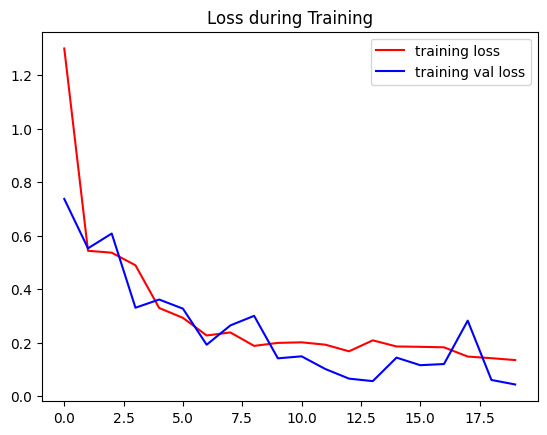

In [18]:
plt.title('Loss during Training')
plt.plot(history.history['loss'], color='red', label='training loss')
plt.plot(history.history['val_loss'], color='blue', label='training val loss')
plt.legend()
plt.show()

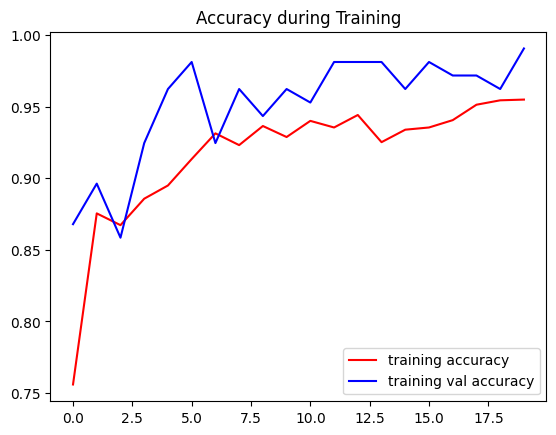

In [19]:
plt.title('Accuracy during Training')
plt.plot(history.history['accuracy'], color='red', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='training val accuracy')
plt.legend()
plt.show()

## Test out the model

In [20]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/Cotton Disease/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 253 images belonging to 4 classes.


In [21]:
score = resnet_v2.evaluate(val_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 4s 465ms/step - loss: 0.1123 - accuracy: 0.9763
Test loss: 0.11234864592552185
Test accuracy: 0.9762845635414124


## Saving the Model

In [22]:
resnet_v2.save('cottonNet_resnet_v2.h5')